##датасет: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

##импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

##загрузка данных

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##EDA

In [ ]:
df.info()
df.isna().mean()
df["Class"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,proportion
Class,
0,0.998273
1,0.001727


дисбаланс между классами(0 - обычные транзакции, 1 - мошеннические). значит метрику accuracy использовать не стоит. лучше смотреть по auc, recall. также модель при обучении должна учитывать дисбаланс классов.

##разделяем выборку данных и проводим нормализацию

In [ ]:
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


##обучаем логистическую регрессию

In [ ]:
model = LogisticRegression(max_iter=2000, class_weight="balanced")
model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

##смотрим метрики

In [ ]:
print(classification_report(y_test, preds))
roc_auc_score(y_test, probs)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



np.float64(0.9720625043067312)

##подготавливаем данные для мониторинга

In [ ]:
df_new = df.sample(20000, random_state=1).copy()
df_new["model_score"] = model.predict_proba(scaler.transform(df_new.drop("Class", axis=1)))[:,1]

##смотрим дрифт по признакам

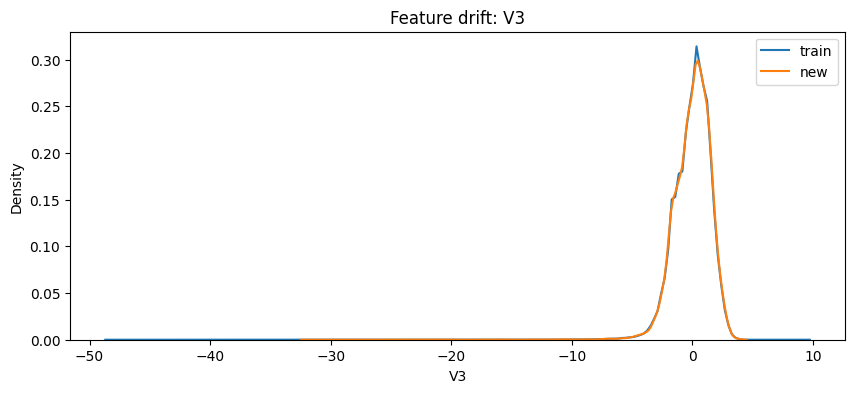

In [ ]:
feature = "V3"
plt.figure(figsize=(10,4))
sns.kdeplot(df[feature], label="train")
sns.kdeplot(df_new[feature], label="new")
plt.legend()
plt.title(f"Feature drift: {feature}")
plt.show()

дрейф отсутствует. данные, которые сейчас подаются на вход модели, не изменились по сравнению с теми данными, на которых модель обучалась. проверим дрифт по еще одному признаку.

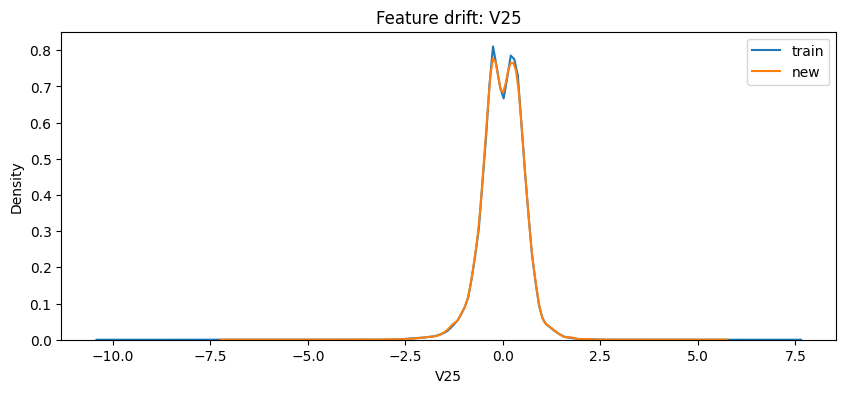

In [ ]:
feature = "V25"
plt.figure(figsize=(10,4))
sns.kdeplot(df[feature], label="train")
sns.kdeplot(df_new[feature], label="new")
plt.legend()
plt.title(f"Feature drift: {feature}")
plt.show()

здесь мы так же видим, что дрейф отсутствует. линии графика практически идентичны.

##проверяем дрифт по предсказаниям модели

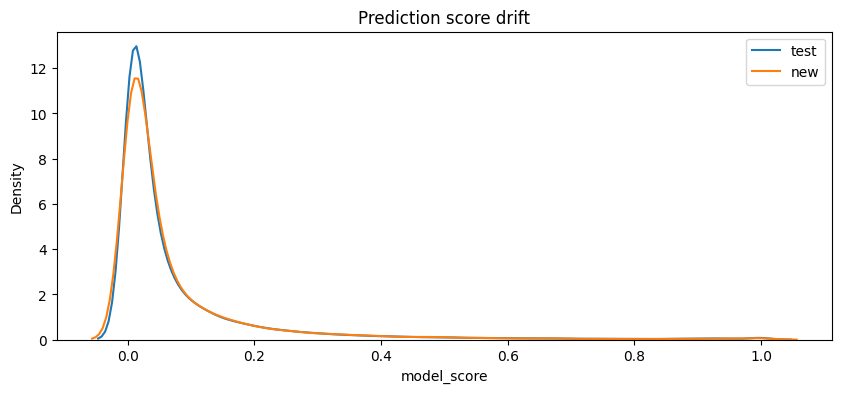

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(probs, label="test")
sns.kdeplot(df_new["model_score"], label="new")
plt.legend()
plt.title("Prediction score drift")
plt.show()

пусть и незначительный, но дрейф наблюдается. либо это связано с дрейфом одного из признаков, либо взаимосвязь между входными данными и целевой переменной изменилась

#мониторинг метрик по времени

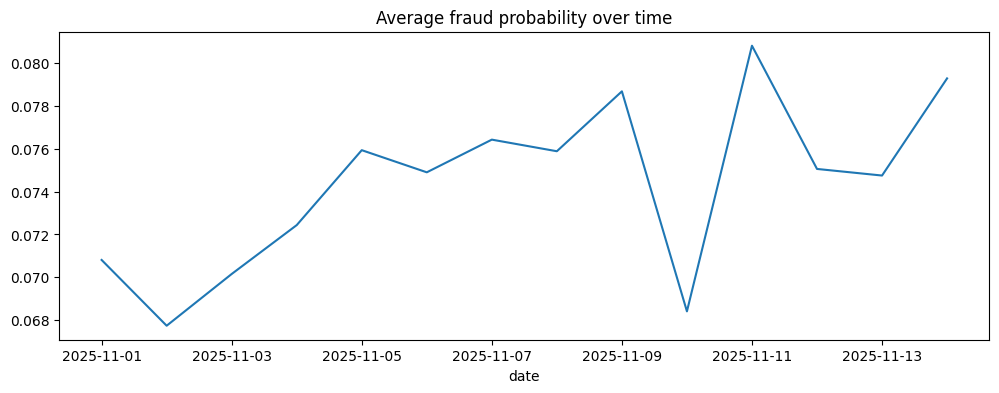

In [ ]:
df_new["timestamp"] = pd.date_range(start="2025-11-01", periods=len(df_new), freq="min")
df_new["date"] = df_new["timestamp"].dt.date

metrics_daily = df_new.groupby("date")["model_score"].mean()
metrics_daily.plot(figsize=(12,4))
plt.title("Average fraud probability over time")
plt.show()

график является прямым следствием дрейфа предсказаний.
дрейф проявляется во времени: например, 10 ноября средний балл модели был значительно выше, чем в другие дни, что говорит о меняющейся интенсивности или характере обнаруженного мошенничества.

##алертинг при обнаружении аномалий

In [ ]:
threshold = metrics_daily.mean() + 1 * metrics_daily.std()
alerts = metrics_daily[metrics_daily > threshold]
alerts

,model_score
date,
2025-11-09,0.078681
2025-11-11,0.080811
2025-11-14,0.079285


при установлении порога как среднее значение + стандартное отклонение, мы видим 3 даты, в которые происходили потенциальные мошеннические транзакции.